In [1]:
cd ..

/home/janek/reasonable-embeddings


In [2]:
import numpy as np
import pandas as pd
import torch as T
import torch.nn.functional as F
import torch.nn as nn
from sklearn import metrics
from src.reasoner_mod import *
from src.generate import load_dataset, prepare_data
from src.reasoner import *
from src.utils import *
from src.vis import *


In [3]:
seed = 2022
dataset_path = 'local/out/dataset/sub-100.json'
ts = timestr()
train_onto, test_onto, data_tr, data_vl, data_te = load_dataset(dataset_path)


In [4]:
data_tr, data_vl, data_te_tr, data_te_vl, idx_te_te, X_te_te, y_te_te = prepare_data(data_tr, data_vl, data_te, seed)

In [5]:
print(np.mean(data_tr[2]))
print(np.mean(data_vl[2]))
print()
print(np.mean(data_te_tr[2]))
print(np.mean(data_te_vl[2]))
print(np.mean(y_te_te))

0.21857221508533675
0.21258330066640532

0.22166126179245282
0.207749766573296
0.20907114010562286


In [6]:
emb_size = 10
hidden_size = 16
epoch_count = 10
test_epoch_count = 10
batch_size = 32

T.manual_seed(seed)
trained_reasoner = ModifiedReasonerHead(emb_size=emb_size, hidden_size=hidden_size)
encoders = [ModifiedEmbeddingLayer.from_onto(onto, emb_size=emb_size) for onto in train_onto]

print(f'created reasoner with {paramcount(trained_reasoner)} parameters')
print(f'created {len(encoders)} encoders with {paramcount(encoders[0])} parameters each')
train_logger = train_mod(data_tr, data_vl, trained_reasoner, encoders, epoch_count=epoch_count,
                          batch_size=batch_size, identities_weight=0.02, identitity_weight_decay=0.95)

created reasoner with 3283 parameters
created 40 encoders with 1270 parameters each
train epoch 00/10 | batch 1704/1703 | loss 0.9680 | val loss 0.7716 | acc 0.2126 | f1 0.3506 | prec 0.2126 | recall 1.0000 | roc auc 0.5113 | pr auc 0.2443 | elapsed 26.82s
train epoch 01/10 | batch 1704/1703 | loss 0.7660 | val loss 0.5140 | acc 0.8135 | f1 0.3203 | prec 0.7113 | recall 0.2067 | roc auc 0.6429 | pr auc 0.4536 | elapsed 50.57s
train epoch 02/10 | batch 1704/1703 | loss 0.5179 | val loss 0.4451 | acc 0.8187 | f1 0.5242 | prec 0.5928 | recall 0.4699 | roc auc 0.7694 | pr auc 0.5974 | elapsed 48.88s
train epoch 03/10 | batch 1704/1703 | loss 0.3830 | val loss 0.4444 | acc 0.8260 | f1 0.5905 | prec 0.5908 | recall 0.5901 | roc auc 0.7994 | pr auc 0.6581 | elapsed 53.82s
train epoch 04/10 | batch 1704/1703 | loss 0.3004 | val loss 0.4623 | acc 0.8249 | f1 0.6088 | prec 0.5797 | recall 0.6410 | roc auc 0.8152 | pr auc 0.6953 | elapsed 53.73s
train epoch 05/10 | batch 1704/1703 | loss 0.2482 |

In [7]:
## --- TESTING
trained_test_encoders = {}
T.manual_seed(seed)
test_logger = TrainingLogger(validate=True, metrics=batch_stats)

for reasoner_name, reasoner in [('trained reasoner', trained_reasoner)]:
    print(reasoner_name)
    T.manual_seed(seed)
    trained_test_encoders[reasoner_name] = test_encoders = [EmbeddingLayer.from_onto(onto, emb_size=emb_size) for onto in test_onto]
    train_mod(data_te_tr, data_te_vl, reasoner, test_encoders, epoch_count=test_epoch_count, batch_size=batch_size, run_name=reasoner_name, freeze_reasoner=True, logger=test_logger)

trained reasoner
train epoch 00/10 | batch 849/848 | loss 0.9576 | val loss 1.2367 | acc 0.6422 | f1 0.4199 | prec 0.3166 | recall 0.6232 | roc auc 0.6868 | pr auc 0.4721 | elapsed 9.22s
train epoch 01/10 | batch 849/848 | loss 0.8368 | val loss 1.0816 | acc 0.6656 | f1 0.4417 | prec 0.3381 | recall 0.6367 | roc auc 0.7152 | pr auc 0.5025 | elapsed 17.56s
train epoch 02/10 | batch 849/848 | loss 0.6025 | val loss 0.9651 | acc 0.6875 | f1 0.4657 | prec 0.3611 | recall 0.6554 | roc auc 0.7416 | pr auc 0.5337 | elapsed 17.05s
train epoch 03/10 | batch 849/848 | loss 0.4378 | val loss 0.8818 | acc 0.7045 | f1 0.4841 | prec 0.3798 | recall 0.6674 | roc auc 0.7632 | pr auc 0.5633 | elapsed 17.27s
train epoch 04/10 | batch 849/848 | loss 0.3282 | val loss 0.8224 | acc 0.7171 | f1 0.5008 | prec 0.3953 | recall 0.6831 | roc auc 0.7804 | pr auc 0.5901 | elapsed 17.47s
train epoch 05/10 | batch 849/848 | loss 0.2567 | val loss 0.7787 | acc 0.7278 | f1 0.5162 | prec 0.4092 | recall 0.6989 | roc au

In [8]:
with T.no_grad():
    # idx_te, X_te, y_te = data_te
    _, _, Y_te_good = eval_batch(trained_reasoner, trained_test_encoders['trained reasoner'], X_te_te, y_te_te, idx_te_te)
    # _, _, Y_te_rand = eval_batch(random_reasoner, trained_test_encoders['random reasoner'], X_te, y_te, idx_te)

local/out/exp/20240713T172501


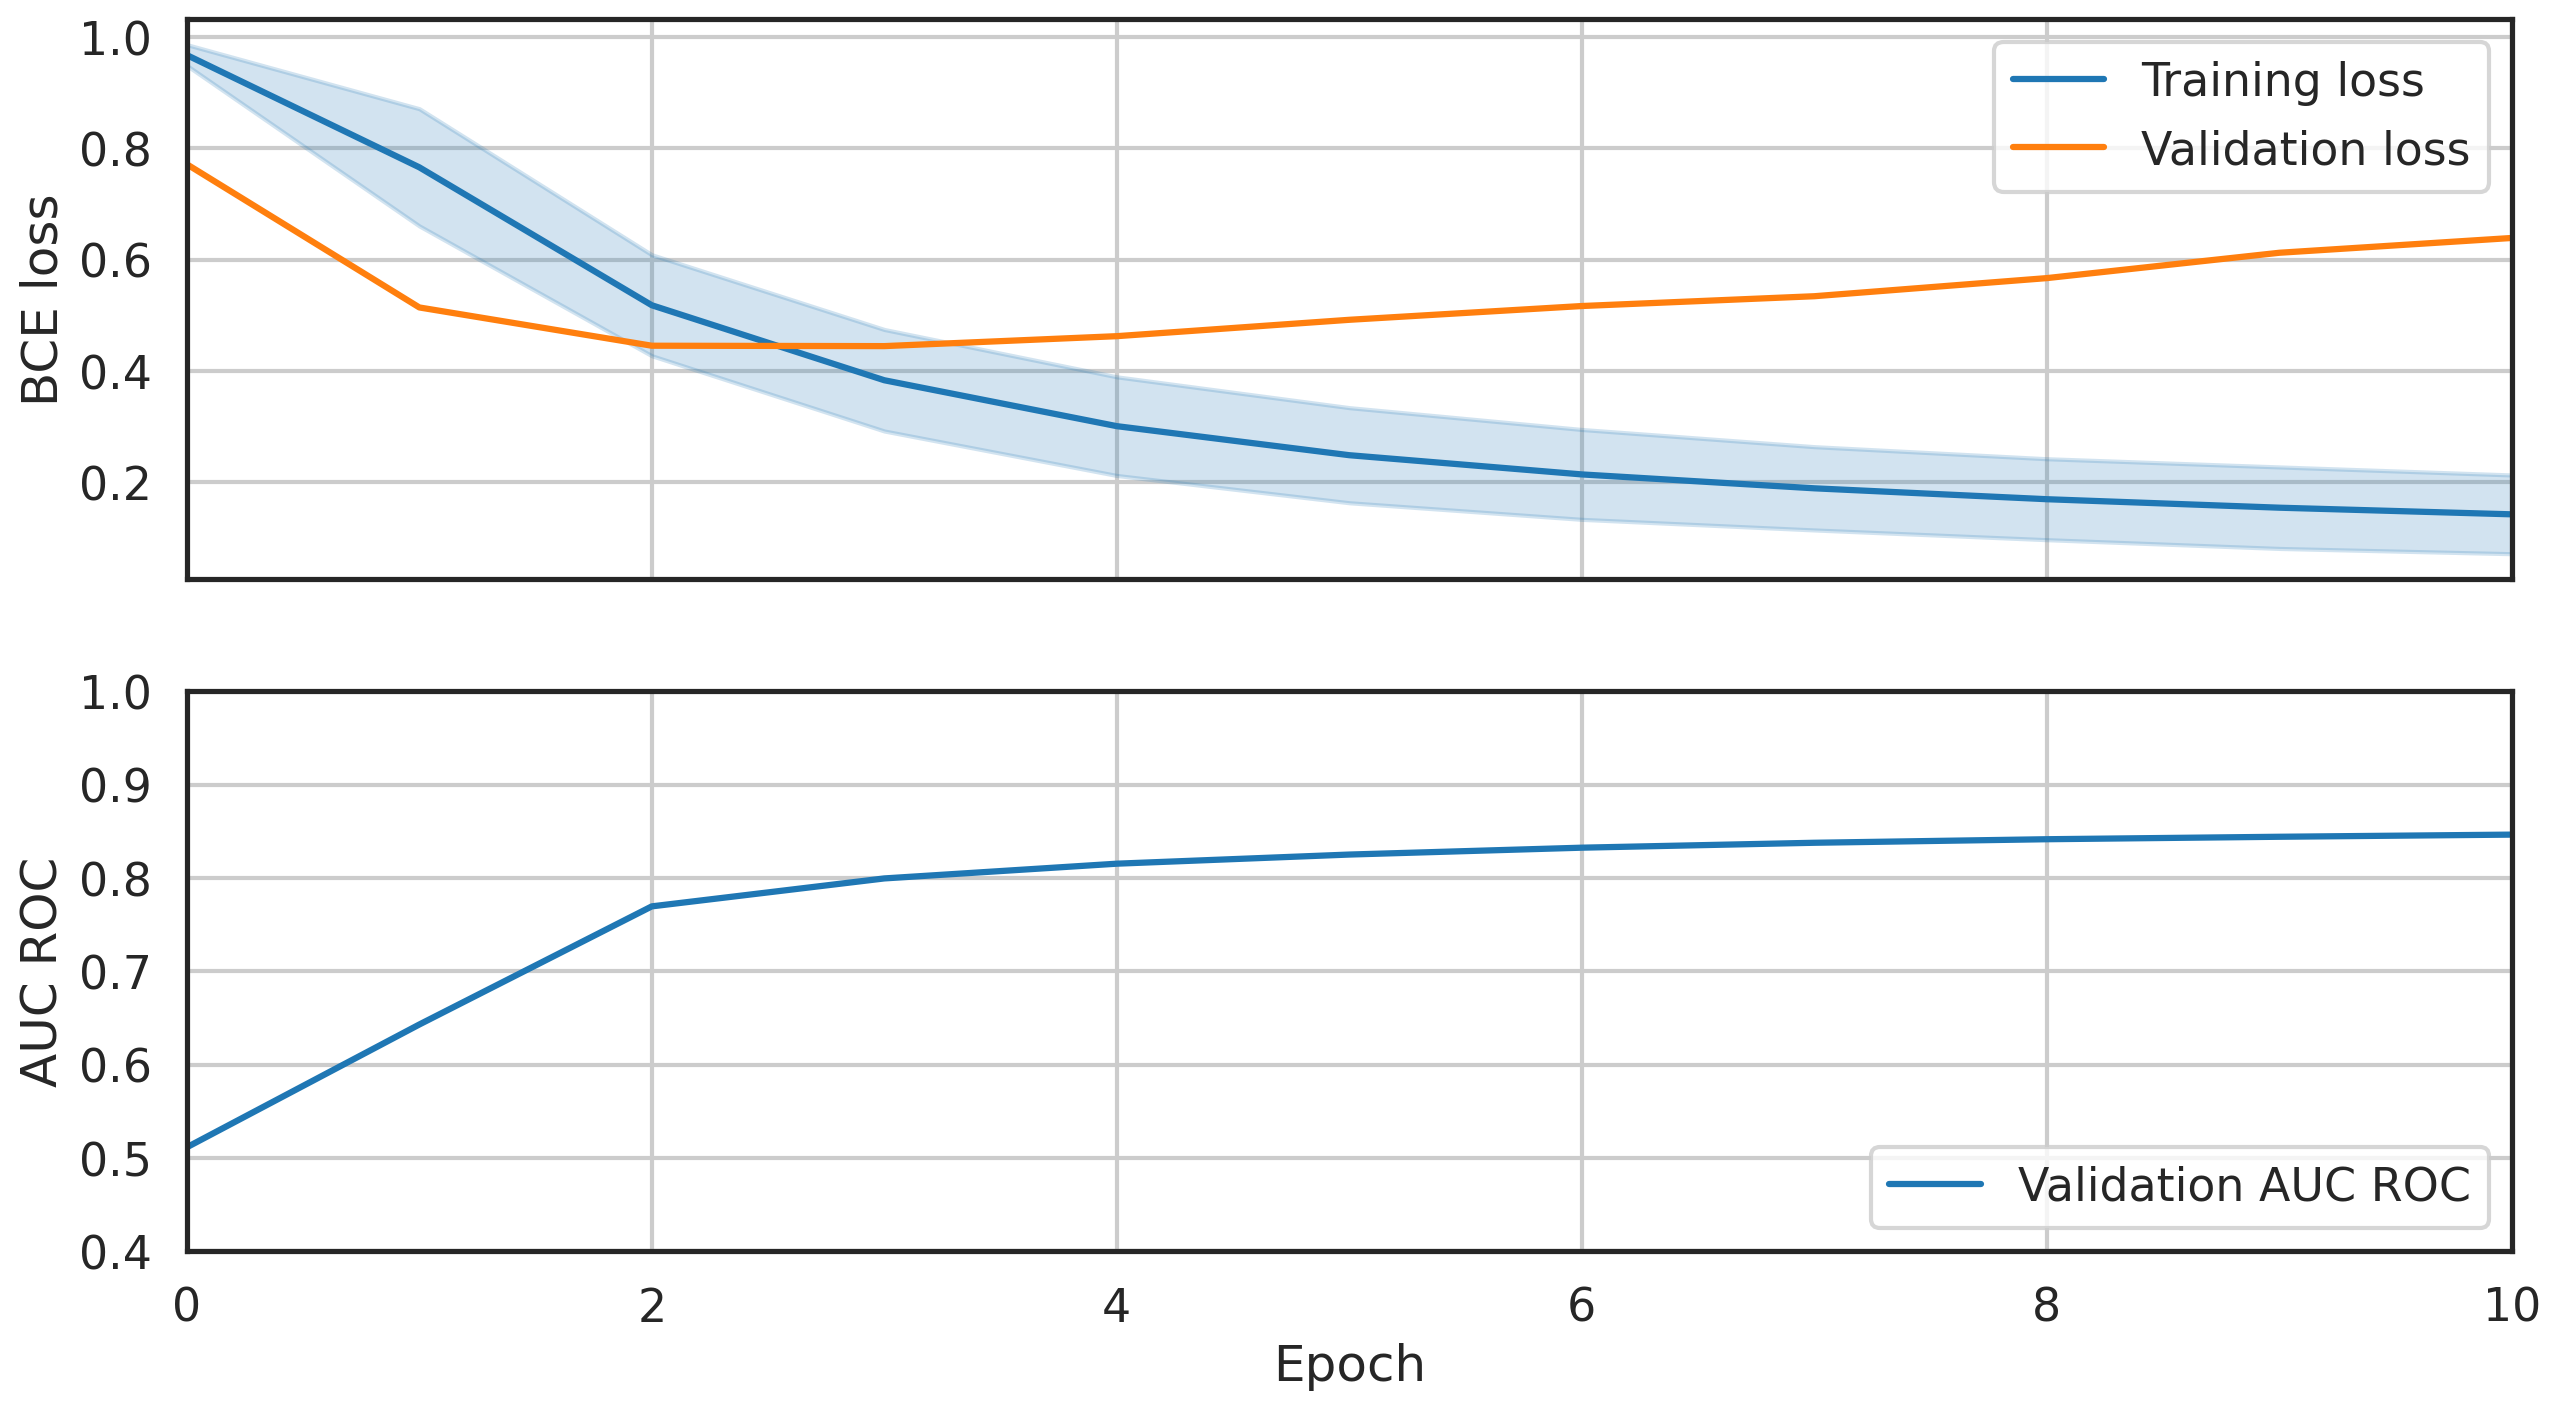

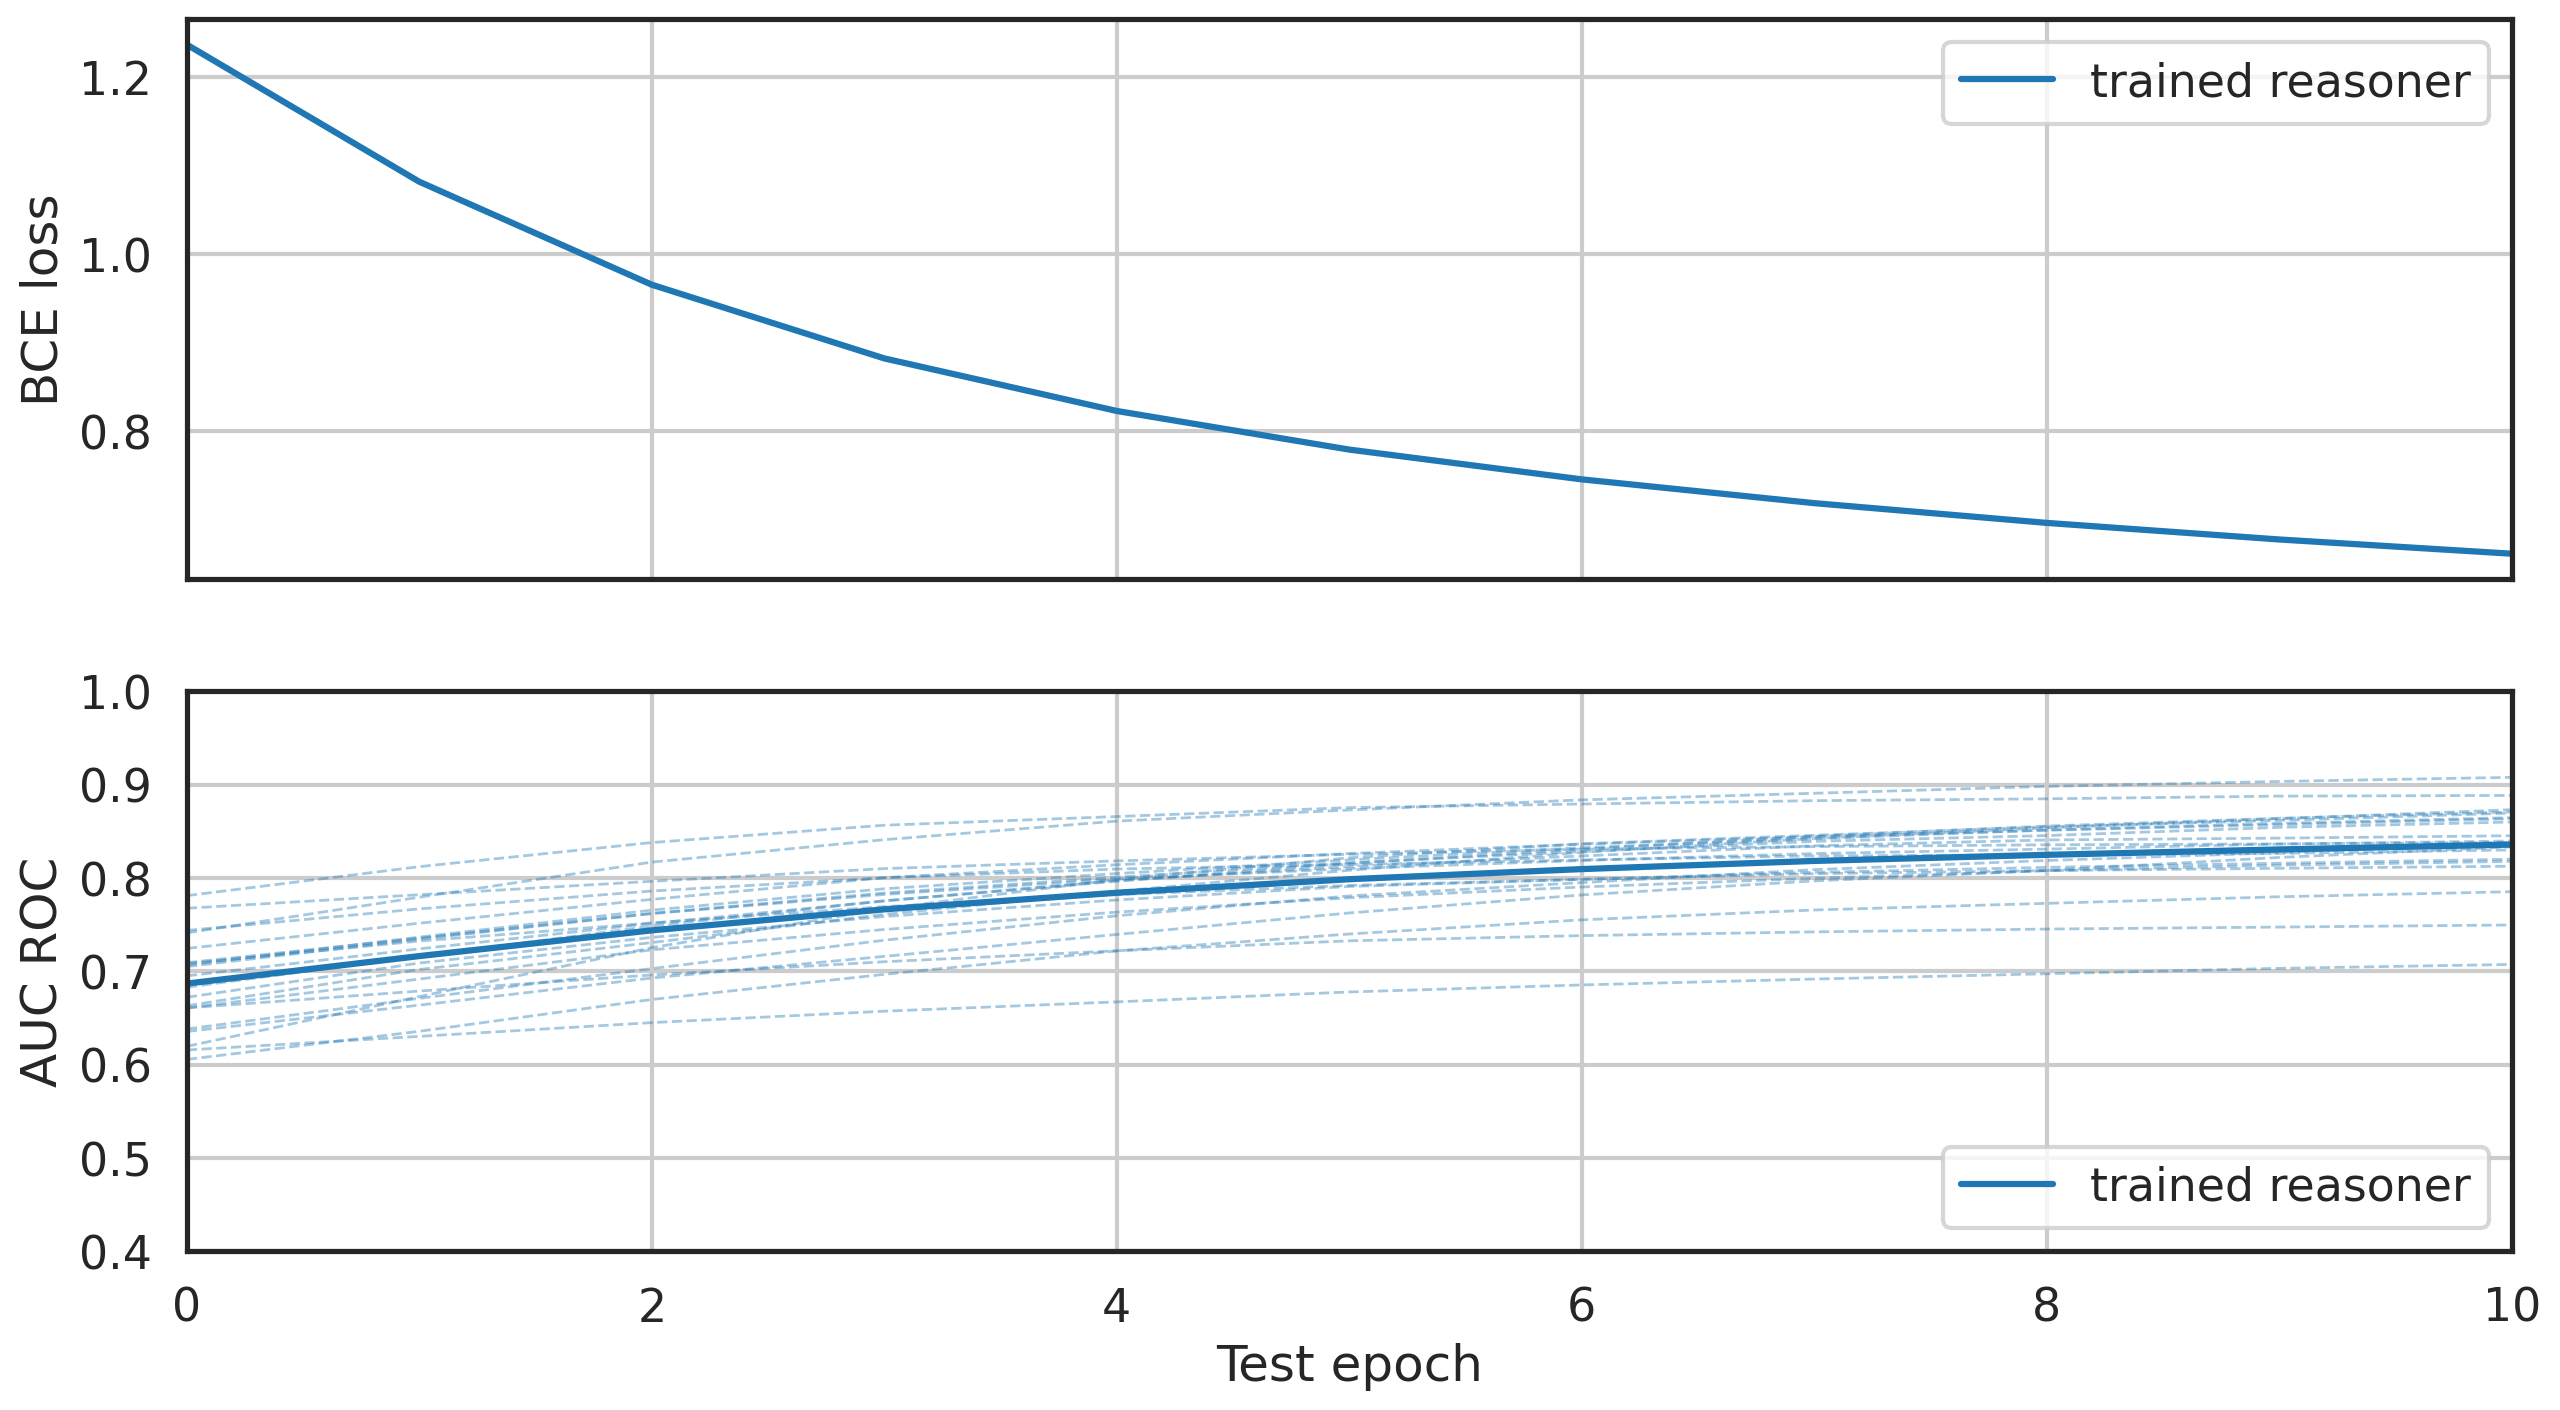

             mean       std     micro
acc      0.779474  0.054614  0.779901
prec     0.489826  0.098651  0.483199
recall   0.767000  0.081977  0.758544
f1       0.591231  0.078847  0.590344
auc_roc  0.857641  0.048869  0.855961
auc_pr   0.735411  0.080428  0.735073


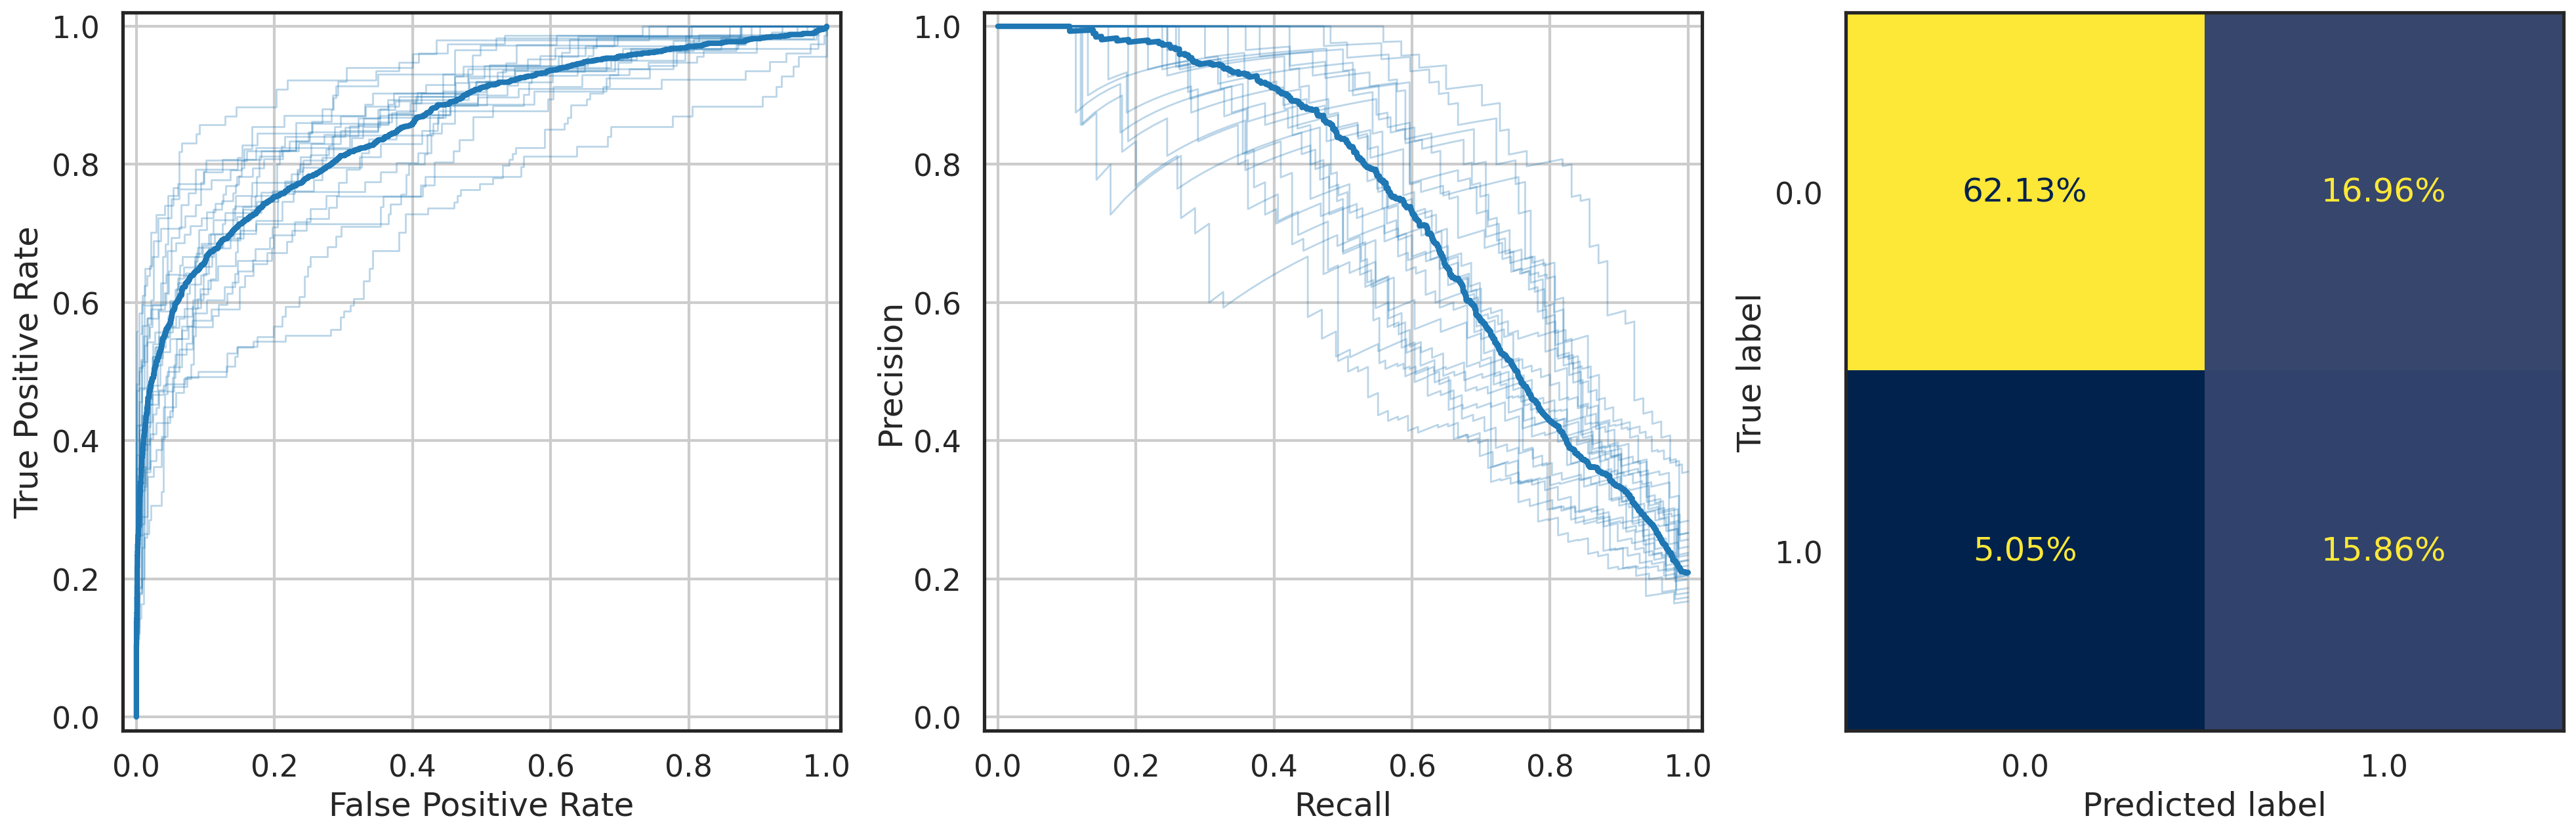

In [9]:
base = 'local/out/exp/' + ts
mkdirp(base)
print(base)

T.save(trained_reasoner.state_dict(), base+'/reasoner.pt')
df_tr = pd.DataFrame(train_logger.history_tr)
df_vl = pd.DataFrame(train_logger.history_vl)
df_tr.to_csv(base+'/train.csv', index=False)
df_vl.to_csv(base+'/valid.csv', index=False)
plot_train_history(df_tr, df_vl, save=base+'/train.png')

test_history_by_onto = pd.DataFrame(test_logger.history_vl_by_onto)
test_history = pd.DataFrame(test_logger.history_vl)
test_results = pd.DataFrame(dict(idx_te=idx_te_te, y_te=y_te_te, Y_te_good=Y_te_good))
test_history.to_csv(base+'/test.csv', index=False)
test_history_by_onto.to_csv(base+'/test-grouped.csv', index=False)
test_results.to_csv(base+'/test-results.csv', index=False)
plot_test_history(test_history, test_history_by_onto)
print(report(test_onto, y_te_te, np.array(Y_te_good), idx_te_te))
# print(report(test_onto, y_te, np.array(Y_te_rand), idx_te))

In [10]:
import random

In [11]:
losses = []
for _ in range(20):
    encoder = trained_test_encoders['trained reasoner'][int(np.round(random.random() * (len(trained_test_encoders['trained reasoner'] ) - 1) , 0))]
    input = encoder.concepts[ int(np.round( random.random() * encoder.n_concepts , 0) - 1) ]
    losses.append( F.l1_loss(input, trained_reasoner.and_nn(im(input, input))).item() )


print(input)
print(trained_reasoner.and_nn(im( input, input)))
print(np.mean(losses))

tensor([-0.0966, -0.1332,  0.1442, -0.0869,  0.0921, -0.0259,  0.0234,  0.1694,
        -0.1469,  0.0270], grad_fn=<SelectBackward0>)
tensor([ 0.2645,  0.1038,  0.1300, -0.2332,  0.3012, -0.0967, -0.0190,  0.0463,
        -0.2015, -0.0953], grad_fn=<AddBackward0>)
0.13216921426355838


In [12]:
losses = []
for _ in range(20):
    encoder = trained_test_encoders['trained reasoner'][int(np.round(random.random() * (len(trained_test_encoders['trained reasoner'] ) - 1) , 0))]
    input = encoder.concepts[ int(np.round( random.random() * encoder.n_concepts , 0) - 1) ]
    losses.append(F.l1_loss(trained_reasoner.and_nn(im(trained_reasoner.bot_concept[0], input)), trained_reasoner.bot_concept[0]).item())
print(trained_reasoner.bot_concept[0])
print(trained_reasoner.and_nn(im(trained_reasoner.bot_concept[0], input)))
print(np.mean(losses))

tensor([ 0.4583,  0.2395,  0.1590, -0.3344,  0.4590, -0.0595,  0.1135,  0.1671,
        -0.2914, -0.2250], grad_fn=<SelectBackward0>)
tensor([ 0.5477,  0.2817,  0.1451, -0.3547,  0.4859,  0.0022,  0.1417,  0.2447,
        -0.3721, -0.2872], grad_fn=<AddBackward0>)
0.036539950501173736


In [13]:
losses = []
for _ in range(20):
    encoder = trained_test_encoders['trained reasoner'][int(np.round(random.random() * (len(trained_test_encoders['trained reasoner'] ) - 1) , 0))]
    input = encoder.concepts[ int(np.round( random.random() * encoder.n_concepts , 0) - 1) ]
    losses.append(F.l1_loss(trained_reasoner.and_nn(im(trained_reasoner.top_concept[0], input)), input).item())

print(input)
print(trained_reasoner.and_nn(im(trained_reasoner.top_concept[0], input)))
print(np.mean(losses))

tensor([ 0.0957,  0.1854, -0.0224, -0.2318,  0.1340,  0.0797,  0.0395,  0.1181,
         0.0391, -0.0885], grad_fn=<SelectBackward0>)
tensor([ 0.1512,  0.0788,  0.0475, -0.1600,  0.1882, -0.0189,  0.0346,  0.0601,
        -0.0834, -0.0794], grad_fn=<AddBackward0>)
0.09140862021595239


In [14]:
losses = []
for _ in range(20):

    encoder = trained_test_encoders['trained reasoner'][int(np.round(random.random() * (len(trained_test_encoders['trained reasoner'] ) - 1) , 0))]
    input = encoder.concepts[ int(np.round( random.random() * encoder.n_concepts , 0) - 1) ]
    output = trained_reasoner.and_nn(im(trained_reasoner.not_nn(input), input))
    losses.append(F.l1_loss(trained_reasoner.bot_concept[0], output).item())

print(trained_reasoner.bot_concept[0])
print(output)
print(np.mean(losses))

tensor([ 0.4583,  0.2395,  0.1590, -0.3344,  0.4590, -0.0595,  0.1135,  0.1671,
        -0.2914, -0.2250], grad_fn=<SelectBackward0>)
tensor([ 0.1826,  0.0029,  0.1254, -0.2394,  0.2464, -0.0837, -0.0341, -0.0100,
        -0.1320,  0.0039], grad_fn=<AddBackward0>)
0.17063427940011025


In [15]:
print(trained_reasoner.bot_concept[0])
output = trained_reasoner.not_nn(trained_reasoner.top_concept[0])
print(output)
print(F.l1_loss(trained_reasoner.bot_concept[0], output))

tensor([ 0.4583,  0.2395,  0.1590, -0.3344,  0.4590, -0.0595,  0.1135,  0.1671,
        -0.2914, -0.2250], grad_fn=<SelectBackward0>)
tensor([ 0.5010,  0.2390,  0.1577, -0.3360,  0.4850, -0.0593,  0.1147,  0.1676,
        -0.3045, -0.2252], grad_fn=<SqueezeBackward3>)
tensor(0.0087, grad_fn=<L1LossBackward0>)


In [16]:
print(trained_reasoner.top_concept[0])
output = trained_reasoner.not_nn(trained_reasoner.bot_concept[0])
print(output)
print(F.l1_loss(trained_reasoner.top_concept[0], output))

tensor([-0.0591, -0.3377, -0.0532,  0.4513,  0.0746,  0.3900,  1.1205, -0.0056,
        -0.2022,  0.4371], grad_fn=<SelectBackward0>)
tensor([-0.0592, -0.3378, -0.0563,  0.4336,  0.0745,  0.3911,  1.0568, -0.0053,
        -0.2060,  0.4157], grad_fn=<SqueezeBackward3>)
tensor(0.0112, grad_fn=<L1LossBackward0>)


In [17]:
losses = []
for _ in range(20):
    encoder = trained_test_encoders['trained reasoner'][int(np.round(random.random() * (len(trained_test_encoders['trained reasoner'] ) - 1) , 0))]
    input1 = encoder.concepts[int(np.round(random. random() * encoder.n_concepts, 0) - 1)]

    input2 = encoder.concepts[int(np.round(random. random() * encoder.n_concepts, 0) - 1)]

    input3 = encoder.concepts[int(np.round(random. random() * encoder.n_concepts, 0) - 1)]

    losses.append(F.l1_loss(trained_reasoner.and_nn(im(input1, trained_reasoner.and_nn(im(input2, input3)))), trained_reasoner.and_nn(im(trained_reasoner.and_nn(im(input1, input2)), input3))).item())

print(trained_reasoner.and_nn(im(input1, trained_reasoner.and_nn(im(input2, input3)))))
print(trained_reasoner.and_nn(im(trained_reasoner.and_nn(im(input1, input2)), input3)))
print(np.mean(losses))

tensor([ 0.2294,  0.0142,  0.1150, -0.2378,  0.2328, -0.0531, -0.0115,  0.0011,
        -0.1084, -0.0058], grad_fn=<AddBackward0>)
tensor([ 0.2295, -0.0298,  0.1448, -0.2173,  0.2206, -0.0980, -0.0200, -0.0103,
        -0.0842, -0.0318], grad_fn=<AddBackward0>)
0.01874222429469228


In [18]:
losses = []
for _ in range(20):
    encoder = trained_test_encoders['trained reasoner'][int(np.round(random.random() * (len(trained_test_encoders['trained reasoner'] ) - 1) , 0))]
    input1 = encoder.concepts[int(np.round(random. random() * encoder.n_concepts, 0) - 1)]
    input2 = encoder.concepts[int(np.round(random. random() * encoder.n_concepts, 0) - 1)]

    losses.append( F.l1_loss(trained_reasoner.and_nn(im(input1, input2)), trained_reasoner.and_nn(im(input2, input1))).item())

print(trained_reasoner.and_nn(im(input1, input2)))
print(trained_reasoner.and_nn(im(input2, input1)))

print(np.mean(losses))

tensor([ 0.1194, -0.0868,  0.1400, -0.1749,  0.1080, -0.1131, -0.0708, -0.0771,
        -0.0021,  0.0513], grad_fn=<AddBackward0>)
tensor([ 0.1312, -0.0759,  0.1190, -0.1948,  0.1156, -0.1147, -0.0925, -0.0734,
         0.0161,  0.0443], grad_fn=<AddBackward0>)
0.024069624952971935


In [19]:
losses = []
for _ in range(20):
    encoder = trained_test_encoders['trained reasoner'][int(np.round(random.random() * (len(trained_test_encoders['trained reasoner'] ) - 1) , 0))]
    input1 = encoder.concepts[int(np.round(random. random() * encoder.n_concepts, 0) - 1)]
    losses.append(F.l1_loss(input1, trained_reasoner.and_nn(im(input1, trained_reasoner.top_concept[0]))).item())

print(input1)
print(trained_reasoner.and_nn(im(input1, trained_reasoner.top_concept[0])))

print(np.mean(losses))

tensor([-0.0827,  0.0740, -0.1024,  0.0428, -0.0083, -0.0097,  0.0604, -0.2518,
        -0.0724, -0.0479], grad_fn=<SelectBackward0>)
tensor([-0.0151, -0.0622, -0.0291,  0.0031,  0.0035, -0.0154, -0.0305, -0.0919,
        -0.0018,  0.0433], grad_fn=<AddBackward0>)
0.07167212385684252


In [20]:
losses = []
for _ in range(20):
    encoder = trained_test_encoders['trained reasoner'][int(np.round(random.random() * (len(trained_test_encoders['trained reasoner'] ) - 1) , 0))]
    input1 = encoder.concepts[int(np.round(random. random() * encoder.n_concepts, 0) - 1)]
    losses.append( T.sigmoid(trained_reasoner.sub_nn(im(input1, trained_reasoner.top_concept[0]))).item())
print(np.mean(losses))

0.9996854990720749


In [21]:
losses = []
for _ in range(20):
    encoder = trained_test_encoders['trained reasoner'][int(np.round(random.random() * (len(trained_test_encoders['trained reasoner'] ) - 1) , 0))]
    input1 = encoder.concepts[int(np.round(random. random() * encoder.n_concepts, 0) - 1)]
    losses.append(T.sigmoid(trained_reasoner.sub_nn(im(trained_reasoner.bot_concept[0], trained_reasoner.bot_concept[0]))).item())
print(np.mean(losses))

0.9999744892120361
